# VISUALIZATION

In [1]:
from visualization import fvis

Using PyTorch version: 0.4.1.post2 CUDA: False

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor



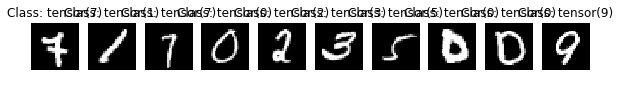

In [2]:
%matplotlib inline
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
#import seaborn as sns

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

validation_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)


for (X_train, y_train) in train_loader:
    print ("")
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    print ("")
    break
    
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i]))

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 128)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), 1)
    
    # Computes the forward activation up to fc1 output. The result of
    # calling this method on a batch of images will be a matrix of size
    # (batchsize, 128) where each ROW is the fc1 feature of the corresponding
    # input image from the batch.
    def extract_fc1(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        return x

    # Computes the forward activation up to fc2 output.
    def extract_fc2(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        return x
    
model = Net()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc2_drop): Dropout(p=0.2)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


## train, validation, test

In [4]:
def train(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='\r')
            
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))
    


In [5]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.691666
Validation set: Average loss: 0.2007, Accuracy: 9377/10000 (93%)

Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.105240
Validation set: Average loss: 0.1365, Accuracy: 9582/10000 (95%)

Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.101377
Validation set: Average loss: 0.1089, Accuracy: 9664/10000 (96%)

Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.057540
Validation set: Average loss: 0.0942, Accuracy: 9697/10000 (96%)

Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.077922
Validation set: Average loss: 0.0876, Accuracy: 9713/10000 (97%)

Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.121354
Validation set: Average loss: 0.0837, Accuracy: 9748/10000 (97%)

Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.151908
Validation set: Average loss: 0.0762, Accuracy: 9760/10000 (97%)

Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.160855
Validation set: Average loss: 0.0734, Accuracy: 9777/10000 (97%)

Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.111891
Validation set: Averag

In [6]:
def extract_features(loader):
    model.eval()
    fc1 = []
    fc2 = []
    labels = []
    for data, target in loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        fc1.append(model.extract_fc1(data))
        fc2.append(model.extract_fc2(data))
        labels.append(target)
    return (torch.cat(fc1), torch.cat(fc2), torch.cat(labels))

In [7]:
(fc1, fc2, labels) = extract_features(validation_loader)

# PCA

In [8]:
fvis.PCA_bokeh(labels,fc1,fc2)

Loading BokehJS ...

# TSNE

In [9]:
fvis.TSNE_bokeh(labels,fc2)

Loading BokehJS ...